# Свёрточные сети

Сегодня мы детальнее поговорим про общие подходы при обучении нейросетей, и что происходит внутри них.

<img width='400px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/cat.png'>

Если попытаться визуализировать то, что выучивает каждый нейрон в нейросети (например, посмотрев, какие входные пиксели на него сильнее всего влияют), то можно увидеть, что чем глубже находится слой, тем более абстрактные фичи он содержит.

Например, в сетях для распознавания картинок первые слои учатся обнаруживать геометрические примитивы: линии, границы, углы. Следующий слой может распознавать простые геометрические фигуры. Следующий распознаёт наличие целых объектов и т. д.

**Weight sharing**. [Эксперименты с дропаутом](https://arxiv.org/abs/1701.05369) показывают, что в линейном слое примерно 99% весов на самом деле можно выкинуть. Логично, что в оптимальной архитектуре не должно быть бесполезных весов — лишние параметры всегда ведут к переобучению. В случае с картинками решение в том, чтобы использовать информацию о расположении пикселей относительно друг друга.

## Свёртки и пуллинги

**Как хранятся картинки**. Когда говорят «изображение», представляйте не прямоугольник, а параллелепипед, высотой которого будет размер каналов. Например, обычные цветные RGB картинки имеют 3 канала: на красный (R), зелёный (G) и синий (B).

0. Введем такую функцию, как **ядро** (англ. **kernel**) — она считает скалярное произведение вектора-входа со своим вектором-параметром.
1. Разобьем исходный паралеллелепипед на сколько-то параллелепипедов одинакового размера вдоль размерности, соответствующей каналам. Они могут пересекаться.
2. Каждый из них «разгладим» в вектор.
3. К кажому такому вектору и применим по очереди каждый кернел (их обычно берут много разных).
4. Положим то, что получилось, в новый параллелепипед.
5. Посчитаем для кажой ячейки какую-нибудь нелинейность. Обычно это ReLU из-за вычислительных причин.

<img width='350px' src='https://raw.githubusercontent.com/sslotin/universum-dl/43390d26d5f256dcc68a6ba51998bd626b3f6d33/images/conv1.png'>

Эта операция называется **свёрткой**. Помимо кернела, в ней есть другие параметры — паддинг (отступ по краям), страйды (шаги по x и y). Также свёртка может быть в 2d и 3d. Посмотрите этот репозиторий, чтобы получше разобраться со свёрточной арифметикой: https://github.com/vdumoulin/conv_arithmetic

![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

**Пулингом** называют операцию, при которой входной тензор так же разбивается на квадраты (не паралепипеды — операция независима по каждому каналу) и на каждом квадрате считается какая-нибудь редукция (чаще всего максимум или среднее по всем значениям в квадрате), после чего полученные значения записываются на следующий слой в том же порядке.

<img width='400px' src='http://cs231n.github.io/assets/cnn/maxpool.jpeg'>

В свёртках переиспользуется очень много параметров: кернел для каждого фильтра (выходного канала) использует один и тот же вектор-параметр для скалярного умножения. Из-за этого каждый фильтр как правило выучивает какую-то конкретную фичу, вроде наличия какого-либо объекта на своём регионе. Пулинг используют затем для понижения размерности: каждый нейрон после свертки выражает степень уверенности, что на регионе присутствует какой-то объект, и поэтому логично в качестве вероятности наличия объекта на регионе из под-регионов использовать максимум или среднее.

Чаще всего используют свёртки 3x3 со страйдом 2x2 (то есть квадраты перекрываются по 3 крайним пикселям) с пулингом размера 2x2 (не перекрываются).

## Аугментация данных

Аугментацией называется процесс получения новых синтетических данных из имеющихся, чтобы подать в обучение. Это часто (особенно в компьютерном зрении) позволяет улучшить качество модели, не используя дополнительных данных.

Формально, в случае с классификацией, аугментация — это любое преобразование, которое корректно изменяет данные, не меняя их класс.

В случае с картинками, можно попробовать добавить следующие преобразования, которые с какой-то вероятностью будут использоваться во время обучения:

* Поворот на малый угол.
* Добавление шума.
* Обрезание границ и последующее растяжение до исходного размера.
* Горизонтальное отражение (но в нашем случае оно вредно).
* Смещение на небольшое расстояние.

Понятно, что лейбл эти преобразования изменить не должны.

<img src='https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/a5da2c3b4174449d13dd746b7d00897c6bc1f334/5-Figure2-1.png' width='500px'>

## Взрывающийся градиент

В сетях происходит очень много чего стохастического: батч формируется случайно, аугментация, рандомизированные слои вроде дропаута, вычислительные ошибки. Это всё может привести к тому, что сеть на какой-то итерации будет очень уверенна в неправильном предсказании и некоторые её параметры получат очень большой градиент. Это может привести к тому, что эти параметры «улетят» куда-то настолько далеко, и после этого сеть будет всегда предсказывать класс, который на этой итерации был правильным. 

Простое решение: просто обрезать градиент в случае, если градиент больше какого-то фиксированного значения. Для этого есть функция `torch.nn.utils.clip_grad_norm_`, которая принимает параметры модели и параметр `threshold`. Она считает норму (длину вектора) градиента и, если она больше `threshold`, нормирует градиенты так, чтобы она была равна `threshold`. Эта функция также возвращает само значение нормы, что может быть очень полезно при анализе обучения (например, если она становится маленькой, то, значит, сеть сходится к какому-то плато).

## Инициализация параметров

Сначала приведем пример плохой инициализации. Пусть мы задали все значения изначально нулями. В таком случае наша модель становится эквивалентна линейной модели — производная по функции потерь одинакова для каждого $w_i$, таким образом, все веса имеют одинаковые значения и в последующей итерации, что делает нейроны в сети симметричными.

Подход получше — инициализировать каждый вес случайно. Но тут нужно быть осторожным — если задать их слишком большими, то сеть может быть изначально очень уверенна в своих предсказаниях, и подвинуть параметры оттуда будет очень трудно.

Решение следующее. С точки зрения слоя, ему на вход подается сэмпл из какого-то распределения, и он под это распределение подстраивается. В нейросетях размеры слоев достаточно большие, чтобы в них работали законы статистики, все разработчики фреймворках условились инициализировать веса всех слоев в предположении, что на вход подаются данные из какого-то распределения со средним 0 и дисперсией 1, и на выходе должно получиться какое-то распределение со средним тоже 0 и дисперсией 1. Чаще всего изначальные веса берут либо из нормального, либо из равномерного распределения, «обрезанного» так, чтобы дисперсия каждого выходного значения получилась единичной.

Аналогично нужно поступать со входными векторными данными: нормализовывать. Это будет важно при работе с изображениями: не надо подавать на вход вектора с элементами от 0 до 255. Самое простое рабочее решение — нормализовать вход, поделив его на 255.

## Минутка физики

Потребляемая энергия в сети с переменным током в единицу времени считается по формуле

$$W = CV^2f$$

где $C$ означает емкость сети, $V$ означает напряжение, а $f$ — частоту. В случае с процессорами, это именно та частота, с которой выполняются элементарные операции, например сложение.

<img width='350px' src='https://i.ibb.co/yhsGRJK/Screenshot-from-2019-02-08-14-52-07.png'>

Однако, если мы сделаем сеть из двух параллельно подключенных процессоров, работающих на половинной частоте, мы можем получить сеть, потребляющую ~40% изначальной энергии, делающую то же количество полезной работы — то же суммарное количество процессорных тактов:

<img width='450px' src='https://i.ibb.co/WgLCxxL/Screenshot-from-2019-02-08-14-52-18.png'>

Поэтому для хорошо распараллеливаемых операций используют другой тип вычислительных устройств, в которых не 4-8 быстрых (3-4 GHz) процессоров, а несколько тысяч медленных (~1GHz).

## Device-agnostic код

К любой модели или тензору в PyTorch можно применить `.cuda()` и `.cpu()`, чтобы перевести тензор на память GPU или в оперативную память соответственно. Но если мы будем писать такой код, нам будет довольно проблематично портировать его на другие машины, где, например, нет GPU (например, если вы хотите скачать тетрадку с colab к себе и запустить).

Многие фреймворки позволяют абстрагироваться от устройства конкретных вычислительных устройств. В PyTorch для этого есть объект `torch.device`, который позволяет явно задавать, на каком устройстве хранить тензор или модель.

In [1]:
import torch
import torch.nn as nn

device = torch.device('cuda:0')  # используй первую GPU (номеруются с нуля)

X = torch.randn(5, 100, device=device)  # создай матрицу на этом устройстве
# альтернативно: X = X.to(device)

# создадим какую-нибудь модель
model = nn.Sequential(
    nn.Linear(100, 20),
    nn.ReLU(),
    nn.Linear(20, 8)
)

model = model.to(device)  # переведи параметры модели на это устройство

model(X)

tensor([[ 0.0299,  0.0464, -0.6815,  0.3696, -0.0938,  0.0494,  0.2382, -0.1576],
        [-0.1022,  0.0341, -0.3400,  0.4548, -0.0685,  0.5520,  0.2421, -0.3103],
        [-0.4015,  0.1306, -0.3222,  0.0423,  0.0232,  0.2476, -0.1826, -0.2957],
        [-0.2482,  0.4176, -0.5821, -0.0656, -0.3767,  0.3583, -0.1161, -0.2335],
        [-0.3376,  0.0476, -0.5606,  0.2106, -0.0903,  0.1223,  0.1128,  0.0932]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Колоризация изображений

Начнём практическую часть. Обучим autoencoder-like сеть, которая учится восстанавливать изображение по его черно-белой версии. В качестве лосса будем так же использовать какую-нибудь меру расстояния между изображениями (например, l1 или l2).

Тот пайплайн, что у нас получится, с минимальными изменениями можно будет также использовать и для других подобных задач, связанных с восстановлением изображений после каких-либо необратимых преобразований, например после подмешивании шума (denoising autoencoder) или понижения размера (DeepHD).

![](https://camo.githubusercontent.com/c5f95c94d70a3e52561c1d0591e84a5e3b86eb74/687474703a2f2f726963687a68616e672e6769746875622e696f2f636f6c6f72697a6174696f6e2f7265736f75726365732f696d616765732f6e65745f6469616772616d2e6a7067)

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Для начала скачаем данные. Годятся вообще любые изображения, не обязательно из какого-то изветсного датасета. Этой командой можно скачать и распакавать фотографии с одной школы по программированию, проходившей этим летом.

In [3]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-03-22 18:48:06--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar.2’

universum_compresse 100%[===================>]  68.69M  6.79MB/s    in 17s     

2022-03-22 18:48:24 (3.93 MB/s) - ‘universum_compressed.tar.2’ saved [72028160/72028160]



Есть два подхода к работе с данными:

1. Сначала преобразовать все имеющиеся данные к виду, который принимает нейросеть (сразу к тензорам одинакового размера).
2. Хранить сырые данные и преобразование препроцессинга (функцию) и собирать батчи на лету.

Если это не что-то совсем простое, то второй вариант предпочтительнее, так как он не требует дополнительной памяти (датасеты могут быть большими), времени на векторизацию датасета, а так же сбор батча «на лету» позволяет там же делать аугментацию.

Для этого в PyTorch есть две абстракции: `Dataset` и `DataLoader`.

`Dataset` — абстрактный класс, от которого нужно отнаследовать класс датасета, который мы напишем. В нём должны быть определён конструктор (в нём обычно загружаются в память сырые данные, которые лежат где-то на диске, а также сохраняется какая-нибудь другая информация), метод `__len__` (должен вернуть размер датасета) и `__getitem__`, который должен по номеру сэмпла вернуть его в виде тензора (возможно, произведя какой-нибудь препроцессинг).

In [4]:
# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне

from tqdm import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


In [5]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                # print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера.

In [6]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

Здесь `transform_all` и `to_grayscale` являются функциями (формально, первый является функтором), которые мы передадим дальше в `DataLoader`, который оборачивает датасет и позволяет итерироваться по нему по батчам, а также реализует разные полезные функции вроде перемешивания данных после каждой эпохи.

In [7]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 710.16it/s]


**Skip-connection**. Иногда бывает полезно присоединить к выходу какого-то слоя его вход, чтобы следующий получил такую же, неизменённую копию. Здесь мы поступим именно так: подадим исходное черно-белое изображение в какую-то одну часть сети, которая сконцентрируется на определении цвета, а затем припишем последним слоем её выход и отправим дальше другому модулю, который уже раскрасит это исходное изображение. От простоты `nn.Sequential`, правда, уже придётся отказаться, и нужно написать свой класс.

In [10]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1), # по дефолту stride = 1, а следовательно размерность не меняется
                                                 # меняем мы только количество каналов
            nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
            nn.ReLU(),

            nn.Conv2d(32, 128, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
            nn.ReLU(),
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # а вот тут мы уменьшаем и высоту, и ширину, в два раза
            nn.ReLU(),

            nn.Upsample(scale_factor=2),         # увеличиваем высоту и ширину в два раза
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=4),         # увеличиваем высоту и ширину в два раза
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1)
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((x, h), 1)
        h = self.postconcat(h)
        return h

Глубокие сети очень часто состоят из повторяющихся блоков, отличающихся только размерностью (в данном случае — количеством фильтров). Чтобы сократить количество кода и уменьшить вероятность багов, блоки можно обернуть в одну функцию, возвращающую мини-модель из нескольких слоев.

Концептуальный пример:

In [9]:
# def Block(channels_in, channels_out):
#     return nn.Sequential(
#         nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
#         # nn.MaxPool2d(4),
#         nn.Dropout(0.3),
#         nn.ReLU(),
#         # nn.BatchNorm2d(0.3),
#     )

# # model = nn.Sequential(
# #     Block(3, 64),
# #     nn.MaxPool2d((2, 2)),
# #     Block(64, 128),
# #     nn.MaxPool2d((2, 2)),
# #     Block(128, 256),
# #     Block(256, 256),
# #     Block(256, 256),
# #     nn.Upsample(),
# #     Block(256, 128),
# #     nn.Upsample(),
# #     Block(128, 64),
# # )

# class Colorizer(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.preconcat = nn.Sequential(
#             Block(1, 64),
#             Block(64, 128),
#             # nn.MaxPool2d((2, 2)),
#             Block(128, 256),
#             # nn.MaxPool2d((2, 2)),
#             Block(256, 512),
#             # nn.Upsample(),
#             Block(512, 512),
#             Block(512, 512),
#             Block(512, 512),
#             Block(512, 256),
#             Block(256, 313),
#         )
         
#         self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
#             nn.Conv2d(314, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
#             nn.ReLU(),
#             nn.Conv2d(32, 3, (3, 3), padding=1)
#         )
    
#     def forward(self, x):
#         h = self.preconcat(x)
#         # исходное чб изображение -- просто дополнительным слоем
#         h = torch.cat((x, h), 1)
#         h = self.postconcat(h)
#         return h

Дальше как обычно:

In [11]:
num_epochs = 500
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [11]:
exit() # в процессе работы переполнилась оперативка ГПУ, пришлось перезапускать рантайм колаба

In [12]:
history = []
for epoch in tqdm(range(num_epochs)):
    for x, y in loader:
        # теперь сами:
        # 0. распакавать данные на нужное устройство
        # 1. сбросить градиент
        # 2. прогнать данные через сеть
        # 3. посчитать loss
        # 4. залоггировать его куда-нибудь
        # 5. сделать .backward()
        # 6. optimizer.step()
        # (7. вывести пример колоризации -- см код ниже)
        #################################################
        train_loss = 0
        #     ^ лэйблы нам не нужны
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        reconstructed = model(x)
        loss = criterion(reconstructed, y)
        
        loss.backward()

        history.append(loss.item())
        optimizer.step()

    print('epoch %d ' % (epoch), history[-1])

  0%|          | 1/500 [00:11<1:33:17, 11.22s/it]

epoch 0  0.29273727536201477


  0%|          | 2/500 [00:22<1:31:18, 11.00s/it]

epoch 1  0.14041182398796082


  1%|          | 3/500 [00:32<1:30:31, 10.93s/it]

epoch 2  0.13051313161849976


  1%|          | 4/500 [00:43<1:30:12, 10.91s/it]

epoch 3  0.10456327348947525


  1%|          | 5/500 [00:54<1:30:47, 11.00s/it]

epoch 4  0.10182903707027435


  1%|          | 6/500 [01:05<1:30:13, 10.96s/it]

epoch 5  0.09362165629863739


  1%|▏         | 7/500 [01:16<1:29:36, 10.91s/it]

epoch 6  0.08887845277786255


  2%|▏         | 8/500 [01:27<1:29:17, 10.89s/it]

epoch 7  0.07723022997379303


  2%|▏         | 9/500 [01:38<1:28:56, 10.87s/it]

epoch 8  0.0811864584684372


  2%|▏         | 10/500 [01:49<1:28:42, 10.86s/it]

epoch 9  0.07876773923635483


  2%|▏         | 11/500 [02:00<1:28:30, 10.86s/it]

epoch 10  0.08280419558286667


  2%|▏         | 12/500 [02:10<1:28:20, 10.86s/it]

epoch 11  0.0709121897816658


  3%|▎         | 13/500 [02:21<1:28:14, 10.87s/it]

epoch 12  0.06865807622671127


  3%|▎         | 14/500 [02:32<1:28:06, 10.88s/it]

epoch 13  0.07564330846071243


  3%|▎         | 15/500 [02:43<1:27:58, 10.88s/it]

epoch 14  0.07176423072814941


  3%|▎         | 16/500 [02:54<1:27:49, 10.89s/it]

epoch 15  0.06736315786838531


  3%|▎         | 17/500 [03:05<1:27:39, 10.89s/it]

epoch 16  0.07532311975955963


  4%|▎         | 18/500 [03:16<1:27:30, 10.89s/it]

epoch 17  0.0709228515625


  4%|▍         | 19/500 [03:27<1:27:22, 10.90s/it]

epoch 18  0.06275128573179245


  4%|▍         | 20/500 [03:38<1:27:08, 10.89s/it]

epoch 19  0.062458544969558716


  4%|▍         | 21/500 [03:48<1:26:56, 10.89s/it]

epoch 20  0.06353092193603516


  4%|▍         | 22/500 [03:59<1:26:51, 10.90s/it]

epoch 21  0.0751049816608429


  5%|▍         | 23/500 [04:10<1:26:41, 10.90s/it]

epoch 22  0.06360291689634323


  5%|▍         | 24/500 [04:21<1:26:31, 10.91s/it]

epoch 23  0.06000543013215065


  5%|▌         | 25/500 [04:32<1:26:19, 10.90s/it]

epoch 24  0.06272836774587631


  5%|▌         | 26/500 [04:43<1:26:02, 10.89s/it]

epoch 25  0.05775311589241028


  5%|▌         | 27/500 [04:54<1:25:54, 10.90s/it]

epoch 26  0.0864788144826889


  6%|▌         | 28/500 [05:05<1:25:44, 10.90s/it]

epoch 27  0.07005947083234787


  6%|▌         | 29/500 [05:16<1:25:34, 10.90s/it]

epoch 28  0.054233815521001816


  6%|▌         | 30/500 [05:27<1:25:23, 10.90s/it]

epoch 29  0.05820193141698837


  6%|▌         | 31/500 [05:37<1:25:12, 10.90s/it]

epoch 30  0.06606484204530716


  6%|▋         | 32/500 [05:48<1:24:56, 10.89s/it]

epoch 31  0.05754808336496353


  7%|▋         | 33/500 [05:59<1:24:41, 10.88s/it]

epoch 32  0.05877837911248207


  7%|▋         | 34/500 [06:10<1:24:31, 10.88s/it]

epoch 33  0.06304251402616501


  7%|▋         | 35/500 [06:21<1:24:19, 10.88s/it]

epoch 34  0.0577683299779892


  7%|▋         | 36/500 [06:32<1:24:10, 10.88s/it]

epoch 35  0.06772817671298981


  7%|▋         | 37/500 [06:43<1:23:51, 10.87s/it]

epoch 36  0.060400303453207016


  8%|▊         | 38/500 [06:54<1:23:34, 10.85s/it]

epoch 37  0.05597732961177826


  8%|▊         | 39/500 [07:04<1:23:19, 10.85s/it]

epoch 38  0.057890478521585464


  8%|▊         | 40/500 [07:15<1:23:06, 10.84s/it]

epoch 39  0.060188423842191696


  8%|▊         | 41/500 [07:26<1:22:57, 10.84s/it]

epoch 40  0.05599842965602875


  8%|▊         | 42/500 [07:37<1:22:45, 10.84s/it]

epoch 41  0.06271455436944962


  9%|▊         | 43/500 [07:48<1:22:38, 10.85s/it]

epoch 42  0.05234585329890251


  9%|▉         | 44/500 [07:59<1:22:32, 10.86s/it]

epoch 43  0.05746800824999809


  9%|▉         | 45/500 [08:10<1:22:28, 10.88s/it]

epoch 44  0.05423470959067345


  9%|▉         | 46/500 [08:20<1:22:18, 10.88s/it]

epoch 45  0.05485609546303749


  9%|▉         | 47/500 [08:31<1:22:06, 10.87s/it]

epoch 46  0.053245704621076584


 10%|▉         | 48/500 [08:42<1:21:52, 10.87s/it]

epoch 47  0.05133038014173508


 10%|▉         | 49/500 [08:53<1:21:37, 10.86s/it]

epoch 48  0.05725198611617088


 10%|█         | 50/500 [09:04<1:21:22, 10.85s/it]

epoch 49  0.0540994331240654


 10%|█         | 51/500 [09:15<1:21:09, 10.85s/it]

epoch 50  0.05240270122885704


 10%|█         | 52/500 [09:25<1:21:02, 10.85s/it]

epoch 51  0.049276892095804214


 11%|█         | 53/500 [09:36<1:20:51, 10.85s/it]

epoch 52  0.05014366656541824


 11%|█         | 54/500 [09:47<1:20:36, 10.84s/it]

epoch 53  0.05486509948968887


 11%|█         | 55/500 [09:58<1:20:25, 10.84s/it]

epoch 54  0.04802791401743889


 11%|█         | 56/500 [10:09<1:20:21, 10.86s/it]

epoch 55  0.04933188483119011


 11%|█▏        | 57/500 [10:20<1:20:11, 10.86s/it]

epoch 56  0.05092658847570419


 12%|█▏        | 58/500 [10:31<1:19:54, 10.85s/it]

epoch 57  0.048799265176057816


 12%|█▏        | 59/500 [10:41<1:19:39, 10.84s/it]

epoch 58  0.05442502349615097


 12%|█▏        | 60/500 [10:52<1:19:25, 10.83s/it]

epoch 59  0.050850797444581985


 12%|█▏        | 61/500 [11:03<1:19:15, 10.83s/it]

epoch 60  0.05624982342123985


 12%|█▏        | 62/500 [11:14<1:19:06, 10.84s/it]

epoch 61  0.05124679207801819


 13%|█▎        | 63/500 [11:25<1:18:57, 10.84s/it]

epoch 62  0.04836113378405571


 13%|█▎        | 64/500 [11:36<1:18:51, 10.85s/it]

epoch 63  0.049954604357481


 13%|█▎        | 65/500 [11:46<1:18:43, 10.86s/it]

epoch 64  0.05195551738142967


 13%|█▎        | 66/500 [11:57<1:18:34, 10.86s/it]

epoch 65  0.05475214123725891


 13%|█▎        | 67/500 [12:08<1:18:18, 10.85s/it]

epoch 66  0.052052732557058334


 14%|█▎        | 68/500 [12:19<1:18:03, 10.84s/it]

epoch 67  0.05570008605718613


 14%|█▍        | 69/500 [12:30<1:17:49, 10.83s/it]

epoch 68  0.05404067039489746


 14%|█▍        | 70/500 [12:41<1:17:34, 10.82s/it]

epoch 69  0.05251367390155792


 14%|█▍        | 71/500 [12:51<1:17:23, 10.82s/it]

epoch 70  0.05857858061790466


 14%|█▍        | 72/500 [13:02<1:17:20, 10.84s/it]

epoch 71  0.0569845475256443


 15%|█▍        | 73/500 [13:13<1:17:14, 10.85s/it]

epoch 72  0.05579229071736336


 15%|█▍        | 74/500 [13:24<1:17:04, 10.86s/it]

epoch 73  0.05587469041347504


 15%|█▌        | 75/500 [13:35<1:16:49, 10.85s/it]

epoch 74  0.06255921721458435


 15%|█▌        | 76/500 [13:46<1:16:35, 10.84s/it]

epoch 75  0.06059088185429573


 15%|█▌        | 77/500 [13:57<1:16:22, 10.83s/it]

epoch 76  0.05098138004541397


 16%|█▌        | 78/500 [14:07<1:16:06, 10.82s/it]

epoch 77  0.046333301812410355


 16%|█▌        | 79/500 [14:18<1:15:59, 10.83s/it]

epoch 78  0.04672185704112053


 16%|█▌        | 80/500 [14:29<1:15:53, 10.84s/it]

epoch 79  0.050641924142837524


 16%|█▌        | 81/500 [14:40<1:15:35, 10.83s/it]

epoch 80  0.04444398358464241


 16%|█▋        | 82/500 [14:51<1:15:24, 10.82s/it]

epoch 81  0.04593103006482124


 17%|█▋        | 83/500 [15:01<1:15:13, 10.82s/it]

epoch 82  0.0497787706553936


 17%|█▋        | 84/500 [15:12<1:15:02, 10.82s/it]

epoch 83  0.043154314160346985


 17%|█▋        | 85/500 [15:23<1:15:01, 10.85s/it]

epoch 84  0.04948819428682327


 17%|█▋        | 86/500 [15:34<1:14:49, 10.84s/it]

epoch 85  0.04657100886106491


 17%|█▋        | 87/500 [15:45<1:14:32, 10.83s/it]

epoch 86  0.047770678997039795


 18%|█▊        | 88/500 [15:56<1:14:21, 10.83s/it]

epoch 87  0.04261225834488869


 18%|█▊        | 89/500 [16:07<1:14:13, 10.84s/it]

epoch 88  0.043524712324142456


 18%|█▊        | 90/500 [16:17<1:14:02, 10.84s/it]

epoch 89  0.047736700624227524


 18%|█▊        | 91/500 [16:28<1:13:56, 10.85s/it]

epoch 90  0.05609506368637085


 18%|█▊        | 92/500 [16:39<1:13:48, 10.85s/it]

epoch 91  0.04480626806616783


 19%|█▊        | 93/500 [16:50<1:13:41, 10.86s/it]

epoch 92  0.04670698568224907


 19%|█▉        | 94/500 [17:01<1:13:33, 10.87s/it]

epoch 93  0.04781349375844002


 19%|█▉        | 95/500 [17:12<1:13:18, 10.86s/it]

epoch 94  0.044811878353357315


 19%|█▉        | 96/500 [17:23<1:13:01, 10.84s/it]

epoch 95  0.044929537922143936


 19%|█▉        | 97/500 [17:33<1:12:48, 10.84s/it]

epoch 96  0.04451809823513031


 20%|█▉        | 98/500 [17:44<1:12:34, 10.83s/it]

epoch 97  0.04092014953494072


 20%|█▉        | 99/500 [17:55<1:12:25, 10.84s/it]

epoch 98  0.04683492332696915


 20%|██        | 100/500 [18:06<1:12:17, 10.84s/it]

epoch 99  0.049239568412303925


 20%|██        | 101/500 [18:17<1:12:05, 10.84s/it]

epoch 100  0.05178432911634445


 20%|██        | 102/500 [18:28<1:11:54, 10.84s/it]

epoch 101  0.05217872932553291


 21%|██        | 103/500 [18:38<1:11:40, 10.83s/it]

epoch 102  0.04478290677070618


 21%|██        | 104/500 [18:49<1:11:30, 10.84s/it]

epoch 103  0.04383184015750885


 21%|██        | 105/500 [19:00<1:11:20, 10.84s/it]

epoch 104  0.05123597010970116


 21%|██        | 106/500 [19:11<1:11:06, 10.83s/it]

epoch 105  0.050814539194107056


 21%|██▏       | 107/500 [19:22<1:11:00, 10.84s/it]

epoch 106  0.0486501045525074


 22%|██▏       | 108/500 [19:33<1:10:53, 10.85s/it]

epoch 107  0.061023611575365067


 22%|██▏       | 109/500 [19:43<1:10:39, 10.84s/it]

epoch 108  0.053803663700819016


 22%|██▏       | 110/500 [19:54<1:10:27, 10.84s/it]

epoch 109  0.04314243420958519


 22%|██▏       | 111/500 [20:05<1:10:13, 10.83s/it]

epoch 110  0.04719395190477371


 22%|██▏       | 112/500 [20:16<1:09:59, 10.82s/it]

epoch 111  0.043249666690826416


 23%|██▎       | 113/500 [20:27<1:09:51, 10.83s/it]

epoch 112  0.04917183890938759


 23%|██▎       | 114/500 [20:38<1:09:47, 10.85s/it]

epoch 113  0.043967701494693756


 23%|██▎       | 115/500 [20:48<1:09:38, 10.85s/it]

epoch 114  0.05422881990671158


 23%|██▎       | 116/500 [20:59<1:09:24, 10.85s/it]

epoch 115  0.04716481640934944


 23%|██▎       | 117/500 [21:10<1:09:11, 10.84s/it]

epoch 116  0.044032178819179535


 24%|██▎       | 118/500 [21:21<1:08:59, 10.84s/it]

epoch 117  0.0488455630838871


 24%|██▍       | 119/500 [21:32<1:08:48, 10.83s/it]

epoch 118  0.05127981677651405


 24%|██▍       | 120/500 [21:43<1:08:34, 10.83s/it]

epoch 119  0.046685852110385895


 24%|██▍       | 121/500 [21:53<1:08:28, 10.84s/it]

epoch 120  0.047189440578222275


 24%|██▍       | 122/500 [22:04<1:08:22, 10.85s/it]

epoch 121  0.04705257713794708


 25%|██▍       | 123/500 [22:15<1:08:04, 10.84s/it]

epoch 122  0.04773103445768356


 25%|██▍       | 124/500 [22:26<1:07:53, 10.83s/it]

epoch 123  0.04866843298077583


 25%|██▌       | 125/500 [22:37<1:07:40, 10.83s/it]

epoch 124  0.040414683520793915


 25%|██▌       | 126/500 [22:48<1:07:29, 10.83s/it]

epoch 125  0.04743970185518265


 25%|██▌       | 127/500 [22:58<1:07:22, 10.84s/it]

epoch 126  0.04569794610142708


 26%|██▌       | 128/500 [23:09<1:07:17, 10.85s/it]

epoch 127  0.04767102375626564


 26%|██▌       | 129/500 [23:20<1:07:07, 10.85s/it]

epoch 128  0.04744543135166168


 26%|██▌       | 130/500 [23:31<1:06:52, 10.84s/it]

epoch 129  0.047240182757377625


 26%|██▌       | 131/500 [23:42<1:06:38, 10.84s/it]

epoch 130  0.04293408244848251


 26%|██▋       | 132/500 [23:53<1:06:29, 10.84s/it]

epoch 131  0.04517173022031784


 27%|██▋       | 133/500 [24:04<1:06:14, 10.83s/it]

epoch 132  0.040585849434137344


 27%|██▋       | 134/500 [24:14<1:06:06, 10.84s/it]

epoch 133  0.049874305725097656


 27%|██▋       | 135/500 [24:25<1:06:00, 10.85s/it]

epoch 134  0.043274860829114914


 27%|██▋       | 136/500 [24:36<1:05:49, 10.85s/it]

epoch 135  0.046046413481235504


 27%|██▋       | 137/500 [24:47<1:05:34, 10.84s/it]

epoch 136  0.05287829041481018


 28%|██▊       | 138/500 [24:58<1:05:24, 10.84s/it]

epoch 137  0.046864960342645645


 28%|██▊       | 139/500 [25:09<1:05:09, 10.83s/it]

epoch 138  0.04188684746623039


 28%|██▊       | 140/500 [25:19<1:04:59, 10.83s/it]

epoch 139  0.04636508598923683


 28%|██▊       | 141/500 [25:30<1:04:50, 10.84s/it]

epoch 140  0.047076623886823654


 28%|██▊       | 142/500 [25:41<1:04:40, 10.84s/it]

epoch 141  0.047689422965049744


 29%|██▊       | 143/500 [25:52<1:04:23, 10.82s/it]

epoch 142  0.04157295823097229


 29%|██▉       | 144/500 [26:03<1:04:11, 10.82s/it]

epoch 143  0.04923344776034355


 29%|██▉       | 145/500 [26:14<1:04:01, 10.82s/it]

epoch 144  0.04906325787305832


 29%|██▉       | 146/500 [26:24<1:03:55, 10.83s/it]

epoch 145  0.044598449021577835


 29%|██▉       | 147/500 [26:35<1:03:45, 10.84s/it]

epoch 146  0.048339955508708954


 30%|██▉       | 148/500 [26:46<1:03:33, 10.83s/it]

epoch 147  0.04418354108929634


 30%|██▉       | 149/500 [26:57<1:03:21, 10.83s/it]

epoch 148  0.045074380934238434


 30%|███       | 150/500 [27:08<1:03:09, 10.83s/it]

epoch 149  0.04501213878393173


 30%|███       | 151/500 [27:19<1:03:01, 10.83s/it]

epoch 150  0.053453899919986725


 30%|███       | 152/500 [27:29<1:02:55, 10.85s/it]

epoch 151  0.04081274941563606


 31%|███       | 153/500 [27:40<1:02:42, 10.84s/it]

epoch 152  0.0553203746676445


 31%|███       | 154/500 [27:51<1:02:29, 10.84s/it]

epoch 153  0.04480191692709923


 31%|███       | 155/500 [28:02<1:02:17, 10.83s/it]

epoch 154  0.04687675088644028


 31%|███       | 156/500 [28:13<1:02:03, 10.82s/it]

epoch 155  0.04605882242321968


 31%|███▏      | 157/500 [28:24<1:01:56, 10.83s/it]

epoch 156  0.046033792197704315


 32%|███▏      | 158/500 [28:34<1:01:42, 10.83s/it]

epoch 157  0.05054435506463051


 32%|███▏      | 159/500 [28:45<1:01:30, 10.82s/it]

epoch 158  0.044863030314445496


 32%|███▏      | 160/500 [28:56<1:01:20, 10.82s/it]

epoch 159  0.04303799942135811


 32%|███▏      | 161/500 [29:07<1:01:07, 10.82s/it]

epoch 160  0.04908466711640358


 32%|███▏      | 162/500 [29:18<1:01:02, 10.84s/it]

epoch 161  0.04822870343923569


 33%|███▎      | 163/500 [29:29<1:00:54, 10.85s/it]

epoch 162  0.04520830139517784


 33%|███▎      | 164/500 [29:39<1:00:39, 10.83s/it]

epoch 163  0.04933641478419304


 33%|███▎      | 165/500 [29:50<1:00:25, 10.82s/it]

epoch 164  0.04705978184938431


 33%|███▎      | 166/500 [30:01<1:00:14, 10.82s/it]

epoch 165  0.04244636371731758


 33%|███▎      | 167/500 [30:12<1:00:05, 10.83s/it]

epoch 166  0.0444212332367897


 34%|███▎      | 168/500 [30:23<1:00:01, 10.85s/it]

epoch 167  0.04308674857020378


 34%|███▍      | 169/500 [30:34<59:46, 10.84s/it]  

epoch 168  0.043744176626205444


 34%|███▍      | 170/500 [30:44<59:34, 10.83s/it]

epoch 169  0.047617051750421524


 34%|███▍      | 171/500 [30:55<59:21, 10.83s/it]

epoch 170  0.04465495049953461


 34%|███▍      | 172/500 [31:06<59:12, 10.83s/it]

epoch 171  0.044918984174728394


 35%|███▍      | 173/500 [31:17<59:03, 10.84s/it]

epoch 172  0.04919033497571945


 35%|███▍      | 174/500 [31:28<58:56, 10.85s/it]

epoch 173  0.04477426037192345


 35%|███▌      | 175/500 [31:39<58:43, 10.84s/it]

epoch 174  0.048577554523944855


 35%|███▌      | 176/500 [31:49<58:27, 10.83s/it]

epoch 175  0.043225426226854324


 35%|███▌      | 177/500 [32:00<58:19, 10.83s/it]

epoch 176  0.04140753671526909


 36%|███▌      | 178/500 [32:11<58:07, 10.83s/it]

epoch 177  0.05191139876842499


 36%|███▌      | 179/500 [32:22<57:59, 10.84s/it]

epoch 178  0.04508866369724274


 36%|███▌      | 180/500 [32:33<57:47, 10.84s/it]

epoch 179  0.04470115900039673


 36%|███▌      | 181/500 [32:43<57:33, 10.83s/it]

epoch 180  0.05324656143784523


 36%|███▋      | 182/500 [32:54<57:21, 10.82s/it]

epoch 181  0.042750049382448196


 37%|███▋      | 183/500 [33:05<57:11, 10.83s/it]

epoch 182  0.04452703520655632


 37%|███▋      | 184/500 [33:16<57:03, 10.83s/it]

epoch 183  0.04295124113559723


 37%|███▋      | 185/500 [33:27<56:50, 10.83s/it]

epoch 184  0.0436435341835022


 37%|███▋      | 186/500 [33:38<56:38, 10.82s/it]

epoch 185  0.049715086817741394


 37%|███▋      | 187/500 [33:48<56:28, 10.83s/it]

epoch 186  0.04662554711103439


 38%|███▊      | 188/500 [33:59<56:15, 10.82s/it]

epoch 187  0.04712199047207832


 38%|███▊      | 189/500 [34:10<56:09, 10.84s/it]

epoch 188  0.04353204369544983


 38%|███▊      | 190/500 [34:21<55:54, 10.82s/it]

epoch 189  0.04435399919748306


 38%|███▊      | 191/500 [34:32<55:43, 10.82s/it]

epoch 190  0.04321662709116936


 38%|███▊      | 192/500 [34:43<55:31, 10.82s/it]

epoch 191  0.04505345597863197


 39%|███▊      | 193/500 [34:53<55:21, 10.82s/it]

epoch 192  0.046965695917606354


 39%|███▉      | 194/500 [35:04<55:13, 10.83s/it]

epoch 193  0.046805787831544876


 39%|███▉      | 195/500 [35:15<55:00, 10.82s/it]

epoch 194  0.051443006843328476


 39%|███▉      | 196/500 [35:26<54:47, 10.81s/it]

epoch 195  0.0390717014670372


 39%|███▉      | 197/500 [35:37<54:37, 10.82s/it]

epoch 196  0.03976394236087799


 40%|███▉      | 198/500 [35:48<54:30, 10.83s/it]

epoch 197  0.05271654203534126


 40%|███▉      | 199/500 [35:58<54:21, 10.84s/it]

epoch 198  0.048888735473155975


 40%|████      | 200/500 [36:09<54:08, 10.83s/it]

epoch 199  0.044833969324827194


 40%|████      | 201/500 [36:20<53:53, 10.81s/it]

epoch 200  0.04389860853552818


 40%|████      | 202/500 [36:31<53:45, 10.82s/it]

epoch 201  0.04399320110678673


 41%|████      | 203/500 [36:42<53:39, 10.84s/it]

epoch 202  0.04216548055410385


 41%|████      | 204/500 [36:53<53:28, 10.84s/it]

epoch 203  0.03845562785863876


 41%|████      | 205/500 [37:03<53:17, 10.84s/it]

epoch 204  0.03990884870290756


 41%|████      | 206/500 [37:14<53:07, 10.84s/it]

epoch 205  0.043504465371370316


 41%|████▏     | 207/500 [37:25<52:54, 10.83s/it]

epoch 206  0.04366672784090042


 42%|████▏     | 208/500 [37:36<52:40, 10.82s/it]

epoch 207  0.043686043471097946


 42%|████▏     | 209/500 [37:47<52:30, 10.83s/it]

epoch 208  0.04326542839407921


 42%|████▏     | 210/500 [37:58<52:24, 10.84s/it]

epoch 209  0.046035803854465485


 42%|████▏     | 211/500 [38:08<52:10, 10.83s/it]

epoch 210  0.04205983877182007


 42%|████▏     | 212/500 [38:19<51:58, 10.83s/it]

epoch 211  0.0422125943005085


 43%|████▎     | 213/500 [38:30<51:44, 10.82s/it]

epoch 212  0.04619608819484711


 43%|████▎     | 214/500 [38:41<51:35, 10.82s/it]

epoch 213  0.04018757864832878


 43%|████▎     | 215/500 [38:52<51:26, 10.83s/it]

epoch 214  0.04114001989364624


 43%|████▎     | 216/500 [39:03<51:21, 10.85s/it]

epoch 215  0.04122002795338631


 43%|████▎     | 217/500 [39:13<51:07, 10.84s/it]

epoch 216  0.04563045874238014


 44%|████▎     | 218/500 [39:24<50:53, 10.83s/it]

epoch 217  0.040522053837776184


 44%|████▍     | 219/500 [39:35<50:41, 10.83s/it]

epoch 218  0.043439555913209915


 44%|████▍     | 220/500 [39:46<50:27, 10.81s/it]

epoch 219  0.04751717671751976


 44%|████▍     | 221/500 [39:57<50:21, 10.83s/it]

epoch 220  0.044194046407938004


 44%|████▍     | 222/500 [40:07<50:10, 10.83s/it]

epoch 221  0.041821274906396866


 45%|████▍     | 223/500 [40:18<49:56, 10.82s/it]

epoch 222  0.051247674971818924


 45%|████▍     | 224/500 [40:29<49:44, 10.81s/it]

epoch 223  0.04435167461633682


 45%|████▌     | 225/500 [40:40<49:33, 10.81s/it]

epoch 224  0.044359542429447174


 45%|████▌     | 226/500 [40:51<49:25, 10.82s/it]

epoch 225  0.04109053686261177


 45%|████▌     | 227/500 [41:01<49:10, 10.81s/it]

epoch 226  0.04198719561100006


 46%|████▌     | 228/500 [41:12<48:58, 10.80s/it]

epoch 227  0.04879622533917427


 46%|████▌     | 229/500 [41:23<48:49, 10.81s/it]

epoch 228  0.047305215150117874


 46%|████▌     | 230/500 [41:34<48:42, 10.82s/it]

epoch 229  0.04029180482029915


 46%|████▌     | 231/500 [41:45<48:35, 10.84s/it]

epoch 230  0.046583615243434906


 46%|████▋     | 232/500 [41:56<48:23, 10.83s/it]

epoch 231  0.04531266540288925


 47%|████▋     | 233/500 [42:06<48:09, 10.82s/it]

epoch 232  0.04380476847290993


 47%|████▋     | 234/500 [42:17<48:00, 10.83s/it]

epoch 233  0.045621782541275024


 47%|████▋     | 235/500 [42:28<47:47, 10.82s/it]

epoch 234  0.042356833815574646


 47%|████▋     | 236/500 [42:39<47:40, 10.84s/it]

epoch 235  0.04209182411432266


 47%|████▋     | 237/500 [42:50<47:30, 10.84s/it]

epoch 236  0.0416940413415432


 48%|████▊     | 238/500 [43:01<47:18, 10.83s/it]

epoch 237  0.040224965661764145


 48%|████▊     | 239/500 [43:11<47:05, 10.83s/it]

epoch 238  0.0426793172955513


 48%|████▊     | 240/500 [43:22<46:52, 10.82s/it]

epoch 239  0.04264134168624878


 48%|████▊     | 241/500 [43:33<46:42, 10.82s/it]

epoch 240  0.047633349895477295


 48%|████▊     | 242/500 [43:44<46:35, 10.83s/it]

epoch 241  0.039947256445884705


 49%|████▊     | 243/500 [43:55<46:25, 10.84s/it]

epoch 242  0.03717413172125816


 49%|████▉     | 244/500 [44:06<46:12, 10.83s/it]

epoch 243  0.03953035920858383


 49%|████▉     | 245/500 [44:16<46:00, 10.82s/it]

epoch 244  0.04678810015320778


 49%|████▉     | 246/500 [44:27<45:48, 10.82s/it]

epoch 245  0.04076692461967468


 49%|████▉     | 247/500 [44:38<45:35, 10.81s/it]

epoch 246  0.04322012886404991


 50%|████▉     | 248/500 [44:49<45:26, 10.82s/it]

epoch 247  0.04175567999482155


 50%|████▉     | 249/500 [45:00<45:12, 10.81s/it]

epoch 248  0.04441029950976372


 50%|█████     | 250/500 [45:10<45:01, 10.80s/it]

epoch 249  0.04523465409874916


 50%|█████     | 251/500 [45:21<44:50, 10.80s/it]

epoch 250  0.040465787053108215


 50%|█████     | 252/500 [45:32<44:46, 10.83s/it]

epoch 251  0.047849398106336594


 51%|█████     | 253/500 [45:43<44:34, 10.83s/it]

epoch 252  0.04381239414215088


 51%|█████     | 254/500 [45:54<44:22, 10.82s/it]

epoch 253  0.044583797454833984


 51%|█████     | 255/500 [46:05<44:08, 10.81s/it]

epoch 254  0.03875681012868881


 51%|█████     | 256/500 [46:15<43:58, 10.81s/it]

epoch 255  0.045339908450841904


 51%|█████▏    | 257/500 [46:26<43:51, 10.83s/it]

epoch 256  0.041128143668174744


 52%|█████▏    | 258/500 [46:37<43:42, 10.84s/it]

epoch 257  0.04763990268111229


 52%|█████▏    | 259/500 [46:48<43:30, 10.83s/it]

epoch 258  0.04307977110147476


 52%|█████▏    | 260/500 [46:59<43:19, 10.83s/it]

epoch 259  0.050509653985500336


 52%|█████▏    | 261/500 [47:10<43:06, 10.82s/it]

epoch 260  0.04637189581990242


 52%|█████▏    | 262/500 [47:20<42:57, 10.83s/it]

epoch 261  0.04400918260216713


 53%|█████▎    | 263/500 [47:31<42:49, 10.84s/it]

epoch 262  0.04646134749054909


 53%|█████▎    | 264/500 [47:42<42:37, 10.84s/it]

epoch 263  0.04468025267124176


 53%|█████▎    | 265/500 [47:53<42:23, 10.82s/it]

epoch 264  0.04331257939338684


 53%|█████▎    | 266/500 [48:04<42:11, 10.82s/it]

epoch 265  0.04313810542225838


 53%|█████▎    | 267/500 [48:14<42:00, 10.82s/it]

epoch 266  0.04202741011977196


 54%|█████▎    | 268/500 [48:25<41:48, 10.81s/it]

epoch 267  0.04256606847047806


 54%|█████▍    | 269/500 [48:36<41:43, 10.84s/it]

epoch 268  0.03525228798389435


 54%|█████▍    | 270/500 [48:47<41:30, 10.83s/it]

epoch 269  0.049249209463596344


 54%|█████▍    | 271/500 [48:58<41:17, 10.82s/it]

epoch 270  0.04855149984359741


 54%|█████▍    | 272/500 [49:09<41:10, 10.83s/it]

epoch 271  0.041495662182569504


 55%|█████▍    | 273/500 [49:19<40:58, 10.83s/it]

epoch 272  0.04064179211854935


 55%|█████▍    | 274/500 [49:30<40:44, 10.82s/it]

epoch 273  0.04419238865375519


 55%|█████▌    | 275/500 [49:41<40:32, 10.81s/it]

epoch 274  0.04522781819105148


 55%|█████▌    | 276/500 [49:52<40:23, 10.82s/it]

epoch 275  0.041003353893756866


 55%|█████▌    | 277/500 [50:03<40:15, 10.83s/it]

epoch 276  0.04096563532948494


 56%|█████▌    | 278/500 [50:14<40:03, 10.83s/it]

epoch 277  0.04671233147382736


 56%|█████▌    | 279/500 [50:24<39:53, 10.83s/it]

epoch 278  0.04071229323744774


 56%|█████▌    | 280/500 [50:35<39:41, 10.83s/it]

epoch 279  0.04490853473544121


 56%|█████▌    | 281/500 [50:46<39:30, 10.82s/it]

epoch 280  0.04017242416739464


 56%|█████▋    | 282/500 [50:57<39:20, 10.83s/it]

epoch 281  0.04530758783221245


 57%|█████▋    | 283/500 [51:08<39:13, 10.84s/it]

epoch 282  0.04172661155462265


 57%|█████▋    | 284/500 [51:19<39:01, 10.84s/it]

epoch 283  0.04524114727973938


 57%|█████▋    | 285/500 [51:29<38:48, 10.83s/it]

epoch 284  0.038920409977436066


 57%|█████▋    | 286/500 [51:40<38:36, 10.83s/it]

epoch 285  0.040871765464544296


 57%|█████▋    | 287/500 [51:51<38:27, 10.83s/it]

epoch 286  0.0395980030298233


 58%|█████▊    | 288/500 [52:02<38:18, 10.84s/it]

epoch 287  0.045054174959659576


 58%|█████▊    | 289/500 [52:13<38:05, 10.83s/it]

epoch 288  0.04077820107340813


 58%|█████▊    | 290/500 [52:24<37:54, 10.83s/it]

epoch 289  0.044778864830732346


 58%|█████▊    | 291/500 [52:34<37:43, 10.83s/it]

epoch 290  0.044234391301870346


 58%|█████▊    | 292/500 [52:45<37:30, 10.82s/it]

epoch 291  0.04082395136356354


 59%|█████▊    | 293/500 [52:56<37:21, 10.83s/it]

epoch 292  0.04285549372434616


 59%|█████▉    | 294/500 [53:07<37:13, 10.84s/it]

epoch 293  0.04896287992596626


 59%|█████▉    | 295/500 [53:18<37:05, 10.86s/it]

epoch 294  0.042593758553266525


 59%|█████▉    | 296/500 [53:29<36:49, 10.83s/it]

epoch 295  0.04047318920493126


 59%|█████▉    | 297/500 [53:39<36:35, 10.82s/it]

epoch 296  0.048654954880476


 60%|█████▉    | 298/500 [53:50<36:25, 10.82s/it]

epoch 297  0.04344913735985756


 60%|█████▉    | 299/500 [54:01<36:17, 10.83s/it]

epoch 298  0.04248594865202904


 60%|██████    | 300/500 [54:12<36:03, 10.82s/it]

epoch 299  0.04379847273230553


 60%|██████    | 301/500 [54:23<35:52, 10.82s/it]

epoch 300  0.04285173490643501


 60%|██████    | 302/500 [54:33<35:41, 10.82s/it]

epoch 301  0.04560547694563866


 61%|██████    | 303/500 [54:44<35:32, 10.82s/it]

epoch 302  0.044970858842134476


 61%|██████    | 304/500 [54:55<35:20, 10.82s/it]

epoch 303  0.046962764114141464


 61%|██████    | 305/500 [55:06<35:07, 10.81s/it]

epoch 304  0.039853863418102264


 61%|██████    | 306/500 [55:17<34:56, 10.81s/it]

epoch 305  0.04988618195056915


 61%|██████▏   | 307/500 [55:28<34:48, 10.82s/it]

epoch 306  0.03974015638232231


 62%|██████▏   | 308/500 [55:38<34:37, 10.82s/it]

epoch 307  0.043685972690582275


 62%|██████▏   | 309/500 [55:49<34:24, 10.81s/it]

epoch 308  0.04073441028594971


 62%|██████▏   | 310/500 [56:00<34:13, 10.81s/it]

epoch 309  0.042011912912130356


 62%|██████▏   | 311/500 [56:11<34:05, 10.82s/it]

epoch 310  0.04381881281733513


 62%|██████▏   | 312/500 [56:22<33:56, 10.83s/it]

epoch 311  0.03962237387895584


 63%|██████▎   | 313/500 [56:32<33:45, 10.83s/it]

epoch 312  0.04484691098332405


 63%|██████▎   | 314/500 [56:43<33:32, 10.82s/it]

epoch 313  0.04470604658126831


 63%|██████▎   | 315/500 [56:54<33:21, 10.82s/it]

epoch 314  0.04346386343240738


 63%|██████▎   | 316/500 [57:05<33:10, 10.82s/it]

epoch 315  0.04673837870359421


 63%|██████▎   | 317/500 [57:16<33:01, 10.83s/it]

epoch 316  0.045472651720047


 64%|██████▎   | 318/500 [57:27<32:53, 10.84s/it]

epoch 317  0.042746707797050476


 64%|██████▍   | 319/500 [57:37<32:41, 10.84s/it]

epoch 318  0.04414365813136101


 64%|██████▍   | 320/500 [57:48<32:29, 10.83s/it]

epoch 319  0.041201088577508926


 64%|██████▍   | 321/500 [57:59<32:18, 10.83s/it]

epoch 320  0.04041358083486557


 64%|██████▍   | 322/500 [58:10<32:06, 10.82s/it]

epoch 321  0.043149739503860474


 65%|██████▍   | 323/500 [58:21<31:57, 10.84s/it]

epoch 322  0.03844060003757477


 65%|██████▍   | 324/500 [58:32<31:45, 10.83s/it]

epoch 323  0.04101399704813957


 65%|██████▌   | 325/500 [58:42<31:33, 10.82s/it]

epoch 324  0.03983993083238602


 65%|██████▌   | 326/500 [58:53<31:20, 10.81s/it]

epoch 325  0.03693116828799248


 65%|██████▌   | 327/500 [59:04<31:11, 10.82s/it]

epoch 326  0.04004707187414169


 66%|██████▌   | 328/500 [59:15<31:02, 10.83s/it]

epoch 327  0.037775639444589615


 66%|██████▌   | 329/500 [59:26<30:50, 10.82s/it]

epoch 328  0.04124012589454651


 66%|██████▌   | 330/500 [59:36<30:38, 10.82s/it]

epoch 329  0.0405450165271759


 66%|██████▌   | 331/500 [59:47<30:30, 10.83s/it]

epoch 330  0.04386276751756668


 66%|██████▋   | 332/500 [59:58<30:19, 10.83s/it]

epoch 331  0.040986910462379456


 67%|██████▋   | 333/500 [1:00:09<30:09, 10.84s/it]

epoch 332  0.04082019254565239


 67%|██████▋   | 334/500 [1:00:20<29:56, 10.82s/it]

epoch 333  0.04224264621734619


 67%|██████▋   | 335/500 [1:00:31<29:44, 10.81s/it]

epoch 334  0.042097531259059906


 67%|██████▋   | 336/500 [1:00:41<29:32, 10.81s/it]

epoch 335  0.04155702888965607


 67%|██████▋   | 337/500 [1:00:52<29:22, 10.81s/it]

epoch 336  0.039725326001644135


 68%|██████▊   | 338/500 [1:01:03<29:11, 10.81s/it]

epoch 337  0.03595665469765663


 68%|██████▊   | 339/500 [1:01:14<28:59, 10.80s/it]

epoch 338  0.04546837508678436


 68%|██████▊   | 340/500 [1:01:25<28:49, 10.81s/it]

epoch 339  0.043472327291965485


 68%|██████▊   | 341/500 [1:01:35<28:37, 10.80s/it]

epoch 340  0.044049207121133804


 68%|██████▊   | 342/500 [1:01:46<28:26, 10.80s/it]

epoch 341  0.036844633519649506


 69%|██████▊   | 343/500 [1:01:57<28:15, 10.80s/it]

epoch 342  0.039044830948114395


 69%|██████▉   | 344/500 [1:02:08<28:05, 10.80s/it]

epoch 343  0.04476484656333923


 69%|██████▉   | 345/500 [1:02:19<27:53, 10.79s/it]

epoch 344  0.03903910890221596


 69%|██████▉   | 346/500 [1:02:29<27:41, 10.79s/it]

epoch 345  0.04294823482632637


 69%|██████▉   | 347/500 [1:02:40<27:31, 10.79s/it]

epoch 346  0.04467141628265381


 70%|██████▉   | 348/500 [1:02:51<27:21, 10.80s/it]

epoch 347  0.045555125921964645


 70%|██████▉   | 349/500 [1:03:02<27:10, 10.80s/it]

epoch 348  0.04151114076375961


 70%|███████   | 350/500 [1:03:13<27:00, 10.80s/it]

epoch 349  0.04132593795657158


 70%|███████   | 351/500 [1:03:23<26:51, 10.81s/it]

epoch 350  0.041550081223249435


 70%|███████   | 352/500 [1:03:34<26:39, 10.81s/it]

epoch 351  0.04881017282605171


 71%|███████   | 353/500 [1:03:45<26:28, 10.81s/it]

epoch 352  0.04121236503124237


 71%|███████   | 354/500 [1:03:56<26:18, 10.81s/it]

epoch 353  0.04199535772204399


 71%|███████   | 355/500 [1:04:07<26:07, 10.81s/it]

epoch 354  0.03868046775460243


 71%|███████   | 356/500 [1:04:18<25:58, 10.82s/it]

epoch 355  0.04496987909078598


 71%|███████▏  | 357/500 [1:04:28<25:45, 10.81s/it]

epoch 356  0.04066990688443184


 72%|███████▏  | 358/500 [1:04:39<25:35, 10.81s/it]

epoch 357  0.03713904321193695


 72%|███████▏  | 359/500 [1:04:50<25:26, 10.83s/it]

epoch 358  0.041386134922504425


 72%|███████▏  | 360/500 [1:05:01<25:14, 10.82s/it]

epoch 359  0.04075723886489868


 72%|███████▏  | 361/500 [1:05:12<25:02, 10.81s/it]

epoch 360  0.04618461802601814


 72%|███████▏  | 362/500 [1:05:22<24:51, 10.81s/it]

epoch 361  0.04333367571234703


 73%|███████▎  | 363/500 [1:05:33<24:41, 10.82s/it]

epoch 362  0.04021404683589935


 73%|███████▎  | 364/500 [1:05:44<24:30, 10.81s/it]

epoch 363  0.04000990837812424


 73%|███████▎  | 365/500 [1:05:55<24:19, 10.81s/it]

epoch 364  0.03696763888001442


 73%|███████▎  | 366/500 [1:06:06<24:08, 10.81s/it]

epoch 365  0.04771139472723007


 73%|███████▎  | 367/500 [1:06:16<24:00, 10.83s/it]

epoch 366  0.04693947732448578


 74%|███████▎  | 368/500 [1:06:27<23:49, 10.83s/it]

epoch 367  0.04014217481017113


 74%|███████▍  | 369/500 [1:06:38<23:38, 10.83s/it]

epoch 368  0.03846629709005356


 74%|███████▍  | 370/500 [1:06:49<23:26, 10.82s/it]

epoch 369  0.041048068553209305


 74%|███████▍  | 371/500 [1:07:00<23:15, 10.82s/it]

epoch 370  0.04241896793246269


 74%|███████▍  | 372/500 [1:07:11<23:06, 10.83s/it]

epoch 371  0.042611755430698395


 75%|███████▍  | 373/500 [1:07:21<22:55, 10.83s/it]

epoch 372  0.04220180958509445


 75%|███████▍  | 374/500 [1:07:32<22:42, 10.81s/it]

epoch 373  0.040086667984724045


 75%|███████▌  | 375/500 [1:07:43<22:31, 10.81s/it]

epoch 374  0.040845200419425964


 75%|███████▌  | 376/500 [1:07:54<22:21, 10.82s/it]

epoch 375  0.04312734678387642


 75%|███████▌  | 377/500 [1:08:05<22:09, 10.81s/it]

epoch 376  0.04427087679505348


 76%|███████▌  | 378/500 [1:08:15<21:58, 10.81s/it]

epoch 377  0.044537924230098724


 76%|███████▌  | 379/500 [1:08:26<21:48, 10.81s/it]

epoch 378  0.040171779692173004


 76%|███████▌  | 380/500 [1:08:37<21:37, 10.81s/it]

epoch 379  0.04395351931452751


 76%|███████▌  | 381/500 [1:08:48<21:25, 10.80s/it]

epoch 380  0.04039039462804794


 76%|███████▋  | 382/500 [1:08:59<21:14, 10.80s/it]

epoch 381  0.04032580927014351


 77%|███████▋  | 383/500 [1:09:09<21:03, 10.80s/it]

epoch 382  0.03841138631105423


 77%|███████▋  | 384/500 [1:09:20<20:55, 10.83s/it]

epoch 383  0.04262332245707512


 77%|███████▋  | 385/500 [1:09:31<20:43, 10.81s/it]

epoch 384  0.04076574370265007


 77%|███████▋  | 386/500 [1:09:42<20:31, 10.81s/it]

epoch 385  0.04036345332860947


 77%|███████▋  | 387/500 [1:09:53<20:20, 10.80s/it]

epoch 386  0.04430534318089485


 78%|███████▊  | 388/500 [1:10:04<20:11, 10.82s/it]

epoch 387  0.04212537035346031


 78%|███████▊  | 389/500 [1:10:14<20:03, 10.84s/it]

epoch 388  0.03807467594742775


 78%|███████▊  | 390/500 [1:10:25<19:54, 10.85s/it]

epoch 389  0.04005420580506325


 78%|███████▊  | 391/500 [1:10:36<19:40, 10.83s/it]

epoch 390  0.03998595103621483


 78%|███████▊  | 392/500 [1:10:47<19:29, 10.82s/it]

epoch 391  0.04493542015552521


 79%|███████▊  | 393/500 [1:10:58<19:17, 10.82s/it]

epoch 392  0.04339023306965828


 79%|███████▉  | 394/500 [1:11:09<19:08, 10.83s/it]

epoch 393  0.04487529769539833


 79%|███████▉  | 395/500 [1:11:19<18:57, 10.84s/it]

epoch 394  0.04742893949151039


 79%|███████▉  | 396/500 [1:11:30<18:46, 10.83s/it]

epoch 395  0.038484521210193634


 79%|███████▉  | 397/500 [1:11:41<18:34, 10.82s/it]

epoch 396  0.038041651248931885


 80%|███████▉  | 398/500 [1:11:52<18:23, 10.82s/it]

epoch 397  0.04337622597813606


 80%|███████▉  | 399/500 [1:12:03<18:14, 10.83s/it]

epoch 398  0.042341820895671844


 80%|████████  | 400/500 [1:12:14<18:02, 10.83s/it]

epoch 399  0.04105295613408089


 80%|████████  | 401/500 [1:12:24<17:51, 10.82s/it]

epoch 400  0.04120240360498428


 80%|████████  | 402/500 [1:12:35<17:40, 10.82s/it]

epoch 401  0.04302386939525604


 81%|████████  | 403/500 [1:12:46<17:29, 10.82s/it]

epoch 402  0.0386454239487648


 81%|████████  | 404/500 [1:12:57<17:20, 10.84s/it]

epoch 403  0.04320070520043373


 81%|████████  | 405/500 [1:13:08<17:08, 10.83s/it]

epoch 404  0.04045100137591362


 81%|████████  | 406/500 [1:13:19<16:57, 10.83s/it]

epoch 405  0.04024872928857803


 81%|████████▏ | 407/500 [1:13:29<16:46, 10.82s/it]

epoch 406  0.046639334410429


 82%|████████▏ | 408/500 [1:13:40<16:35, 10.82s/it]

epoch 407  0.041508737951517105


 82%|████████▏ | 409/500 [1:13:51<16:26, 10.84s/it]

epoch 408  0.038562409579753876


 82%|████████▏ | 410/500 [1:14:02<16:15, 10.83s/it]

epoch 409  0.040841296315193176


 82%|████████▏ | 411/500 [1:14:13<16:03, 10.82s/it]

epoch 410  0.04732615500688553


 82%|████████▏ | 412/500 [1:14:24<15:52, 10.82s/it]

epoch 411  0.03687093034386635


 83%|████████▎ | 413/500 [1:14:34<15:41, 10.82s/it]

epoch 412  0.043335359543561935


 83%|████████▎ | 414/500 [1:14:45<15:31, 10.83s/it]

epoch 413  0.04162999987602234


 83%|████████▎ | 415/500 [1:14:56<15:20, 10.83s/it]

epoch 414  0.043612685054540634


 83%|████████▎ | 416/500 [1:15:07<15:09, 10.82s/it]

epoch 415  0.040531765669584274


 83%|████████▎ | 417/500 [1:15:18<14:57, 10.81s/it]

epoch 416  0.03789600357413292


 84%|████████▎ | 418/500 [1:15:28<14:46, 10.81s/it]

epoch 417  0.04842580482363701


 84%|████████▍ | 419/500 [1:15:39<14:36, 10.82s/it]

epoch 418  0.05187513679265976


 84%|████████▍ | 420/500 [1:15:50<14:25, 10.82s/it]

epoch 419  0.042122237384319305


 84%|████████▍ | 421/500 [1:16:01<14:13, 10.81s/it]

epoch 420  0.0368473045527935


 84%|████████▍ | 422/500 [1:16:12<14:03, 10.81s/it]

epoch 421  0.04273129999637604


 85%|████████▍ | 423/500 [1:16:23<13:53, 10.82s/it]

epoch 422  0.043348751962184906


 85%|████████▍ | 424/500 [1:16:33<13:41, 10.81s/it]

epoch 423  0.04067983105778694


 85%|████████▌ | 425/500 [1:16:44<13:30, 10.80s/it]

epoch 424  0.04082927107810974


 85%|████████▌ | 426/500 [1:16:55<13:19, 10.80s/it]

epoch 425  0.042982593178749084


 85%|████████▌ | 427/500 [1:17:06<13:09, 10.82s/it]

epoch 426  0.03959790617227554


 86%|████████▌ | 428/500 [1:17:17<12:58, 10.81s/it]

epoch 427  0.041132599115371704


 86%|████████▌ | 429/500 [1:17:27<12:47, 10.81s/it]

epoch 428  0.03782172128558159


 86%|████████▌ | 430/500 [1:17:38<12:36, 10.81s/it]

epoch 429  0.04184625670313835


 86%|████████▌ | 431/500 [1:17:49<12:27, 10.83s/it]

epoch 430  0.04061224311590195


 86%|████████▋ | 432/500 [1:18:00<12:15, 10.82s/it]

epoch 431  0.04676930233836174


 87%|████████▋ | 433/500 [1:18:11<12:04, 10.82s/it]

epoch 432  0.045229289680719376


 87%|████████▋ | 434/500 [1:18:21<11:54, 10.82s/it]

epoch 433  0.04154910892248154


 87%|████████▋ | 435/500 [1:18:32<11:44, 10.83s/it]

epoch 434  0.03798070177435875


 87%|████████▋ | 436/500 [1:18:43<11:34, 10.85s/it]

epoch 435  0.03781377524137497


 87%|████████▋ | 437/500 [1:18:54<11:22, 10.83s/it]

epoch 436  0.04321025311946869


 88%|████████▊ | 438/500 [1:19:05<11:11, 10.83s/it]

epoch 437  0.04018554836511612


 88%|████████▊ | 439/500 [1:19:16<11:00, 10.83s/it]

epoch 438  0.042602431029081345


 88%|████████▊ | 440/500 [1:19:26<10:49, 10.83s/it]

epoch 439  0.040672410279512405


 88%|████████▊ | 441/500 [1:19:37<10:40, 10.85s/it]

epoch 440  0.0443141795694828


 88%|████████▊ | 442/500 [1:19:48<10:28, 10.84s/it]

epoch 441  0.04572144150733948


 89%|████████▊ | 443/500 [1:19:59<10:18, 10.84s/it]

epoch 442  0.04093034937977791


 89%|████████▉ | 444/500 [1:20:10<10:06, 10.83s/it]

epoch 443  0.040675174444913864


 89%|████████▉ | 445/500 [1:20:21<09:55, 10.83s/it]

epoch 444  0.04219691827893257


 89%|████████▉ | 446/500 [1:20:32<09:45, 10.84s/it]

epoch 445  0.03891830891370773


 89%|████████▉ | 447/500 [1:20:42<09:34, 10.83s/it]

epoch 446  0.04028784856200218


 90%|████████▉ | 448/500 [1:20:53<09:22, 10.83s/it]

epoch 447  0.04266653209924698


 90%|████████▉ | 449/500 [1:21:04<09:11, 10.82s/it]

epoch 448  0.04439419507980347


 90%|█████████ | 450/500 [1:21:15<09:01, 10.82s/it]

epoch 449  0.04481661692261696


 90%|█████████ | 451/500 [1:21:26<08:50, 10.82s/it]

epoch 450  0.040412537753582


 90%|█████████ | 452/500 [1:21:36<08:39, 10.82s/it]

epoch 451  0.046011362224817276


 91%|█████████ | 453/500 [1:21:47<08:28, 10.81s/it]

epoch 452  0.04151773452758789


 91%|█████████ | 454/500 [1:21:58<08:17, 10.82s/it]

epoch 453  0.042511072009801865


 91%|█████████ | 455/500 [1:22:09<08:06, 10.82s/it]

epoch 454  0.04334307089447975


 91%|█████████ | 456/500 [1:22:20<07:56, 10.83s/it]

epoch 455  0.04316172003746033


 91%|█████████▏| 457/500 [1:22:31<07:45, 10.82s/it]

epoch 456  0.04549672454595566


 92%|█████████▏| 458/500 [1:22:41<07:34, 10.83s/it]

epoch 457  0.044027119874954224


 92%|█████████▏| 459/500 [1:22:52<07:23, 10.82s/it]

epoch 458  0.040428612381219864


 92%|█████████▏| 460/500 [1:23:03<07:13, 10.83s/it]

epoch 459  0.04247250035405159


 92%|█████████▏| 461/500 [1:23:14<07:02, 10.83s/it]

epoch 460  0.04184767231345177


 92%|█████████▏| 462/500 [1:23:25<06:51, 10.83s/it]

epoch 461  0.04254449903964996


 93%|█████████▎| 463/500 [1:23:36<06:40, 10.83s/it]

epoch 462  0.042810145765542984


 93%|█████████▎| 464/500 [1:23:46<06:29, 10.83s/it]

epoch 463  0.03803836926817894


 93%|█████████▎| 465/500 [1:23:57<06:18, 10.83s/it]

epoch 464  0.041627127677202225


 93%|█████████▎| 466/500 [1:24:08<06:07, 10.82s/it]

epoch 465  0.04247468337416649


 93%|█████████▎| 467/500 [1:24:19<05:57, 10.83s/it]

epoch 466  0.03783317655324936


 94%|█████████▎| 468/500 [1:24:30<05:45, 10.81s/it]

epoch 467  0.04258265718817711


 94%|█████████▍| 469/500 [1:24:40<05:35, 10.82s/it]

epoch 468  0.04580762982368469


 94%|█████████▍| 470/500 [1:24:51<05:24, 10.82s/it]

epoch 469  0.041061267256736755


 94%|█████████▍| 471/500 [1:25:02<05:14, 10.84s/it]

epoch 470  0.04102693498134613


 94%|█████████▍| 472/500 [1:25:13<05:04, 10.86s/it]

epoch 471  0.04441863298416138


 95%|█████████▍| 473/500 [1:25:24<04:53, 10.87s/it]

epoch 472  0.040127526968717575


 95%|█████████▍| 474/500 [1:25:35<04:42, 10.87s/it]

epoch 473  0.045931827276945114


 95%|█████████▌| 475/500 [1:25:46<04:31, 10.85s/it]

epoch 474  0.04114798083901405


 95%|█████████▌| 476/500 [1:25:56<04:20, 10.84s/it]

epoch 475  0.040838487446308136


 95%|█████████▌| 477/500 [1:26:07<04:09, 10.83s/it]

epoch 476  0.04469974339008331


 96%|█████████▌| 478/500 [1:26:18<03:58, 10.86s/it]

epoch 477  0.043576378375291824


 96%|█████████▌| 479/500 [1:26:29<03:48, 10.87s/it]

epoch 478  0.03900507092475891


 96%|█████████▌| 480/500 [1:26:40<03:37, 10.86s/it]

epoch 479  0.042186349630355835


 96%|█████████▌| 481/500 [1:26:51<03:26, 10.85s/it]

epoch 480  0.03841666504740715


 96%|█████████▋| 482/500 [1:27:02<03:15, 10.84s/it]

epoch 481  0.03720930218696594


 97%|█████████▋| 483/500 [1:27:12<03:04, 10.85s/it]

epoch 482  0.03797423467040062


 97%|█████████▋| 484/500 [1:27:23<02:53, 10.85s/it]

epoch 483  0.04230552911758423


 97%|█████████▋| 485/500 [1:27:34<02:43, 10.87s/it]

epoch 484  0.04120500385761261


 97%|█████████▋| 486/500 [1:27:45<02:32, 10.88s/it]

epoch 485  0.03943780064582825


 97%|█████████▋| 487/500 [1:27:56<02:21, 10.88s/it]

epoch 486  0.040078602731227875


 98%|█████████▊| 488/500 [1:28:07<02:10, 10.87s/it]

epoch 487  0.03698625788092613


 98%|█████████▊| 489/500 [1:28:18<01:59, 10.86s/it]

epoch 488  0.03973330929875374


 98%|█████████▊| 490/500 [1:28:28<01:48, 10.86s/it]

epoch 489  0.04790709540247917


 98%|█████████▊| 491/500 [1:28:39<01:37, 10.86s/it]

epoch 490  0.0486159585416317


 98%|█████████▊| 492/500 [1:28:50<01:26, 10.85s/it]

epoch 491  0.03703847900032997


 99%|█████████▊| 493/500 [1:29:01<01:15, 10.86s/it]

epoch 492  0.04577483609318733


 99%|█████████▉| 494/500 [1:29:12<01:05, 10.86s/it]

epoch 493  0.037140846252441406


 99%|█████████▉| 495/500 [1:29:23<00:54, 10.85s/it]

epoch 494  0.037227753549814224


 99%|█████████▉| 496/500 [1:29:34<00:43, 10.85s/it]

epoch 495  0.038918767124414444


 99%|█████████▉| 497/500 [1:29:44<00:32, 10.86s/it]

epoch 496  0.039026640355587006


100%|█████████▉| 498/500 [1:29:55<00:21, 10.85s/it]

epoch 497  0.0384332649409771


100%|█████████▉| 499/500 [1:30:06<00:10, 10.85s/it]

epoch 498  0.04487543925642967


100%|██████████| 500/500 [1:30:17<00:00, 10.84s/it]

epoch 499  0.03809872642159462


В подобных нечётко поставленных задачах важно смотреть не цифры, а на реальные примеры.


In [13]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

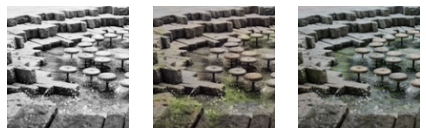

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


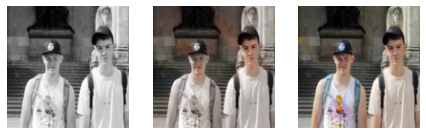

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


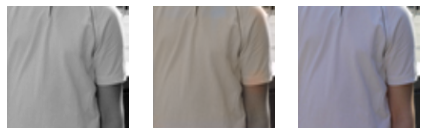

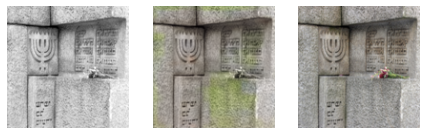

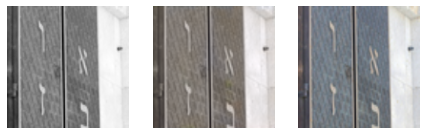

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


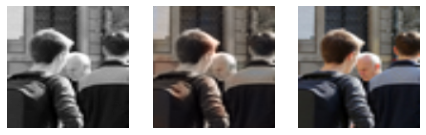

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


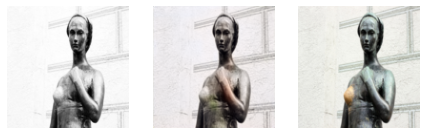

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


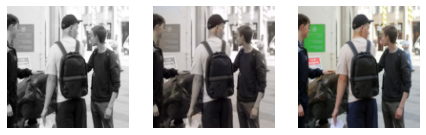

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


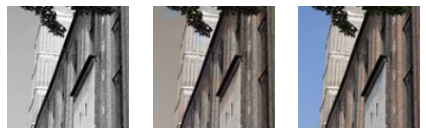

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


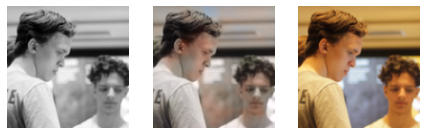

In [14]:
for t in range(10):
    img_gray, img_true = dataset[t]
    img_gray = img_gray.to(device)
    img_pred = model(img_gray.view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.cpu().reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

## *Тизер: adversarial loss

У нашего подхода к колоризации есть одна весьма существенная проблема: непонятно, как определять функцию потерь. Выясняется, что l1 или l2 в некоторых случаях даже являются принципиально неправильным выбором. Представьте, что у нас есть датасет фотографий с летнего лагеря, в котором все люди ходят в футболках двух разных цветов — например, красного и синего — интенсивность которых одинакова и неотличима на черно-белых версиях. Тогда наш лосс заставит сеть выбирать что-то «по середине» (в случае с l2 это будет среднее, а с l1 медиана), и, скорее всего, она сгенерирует что-то серое, в то время как она должна с какой-то вероятностью сгенерировать явно красную или явно синюю футболку.

Решение в следующем: выход (колоризованное изображение) кормить в другую сеть, которая учится определять «правдоподобность» раскраски. Помимо восстановления изображения с точки зрения какой-то меры близости, сети-генератору (колоризатору) нужно ещё и обмануть сеть-дискриминатор, а сети-дискриминатору нужно наоборот, учиться отличать настоящую колоризацию от нашей.

Подобные схемы с двумя состязяющимися сетями называют GAN-ам (Generative Adversarial Networks), о которых мы поговорим через занятие.